In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv('/kaggle/input/daataa/churn_data.csv') 
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True) 

df = df.drop('customerID', axis=1)

label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print("Data Cleaned Successfully!")

Data Cleaned Successfully!


In [4]:
X = df.drop('Churn', axis=1) 
y = df['Churn']             

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
import plotly.express as px

fig = px.histogram(
    df,
    x="Churn",   
    color="Churn",
    title="Churn Distribution",
    text_auto=True
)
fig.show()

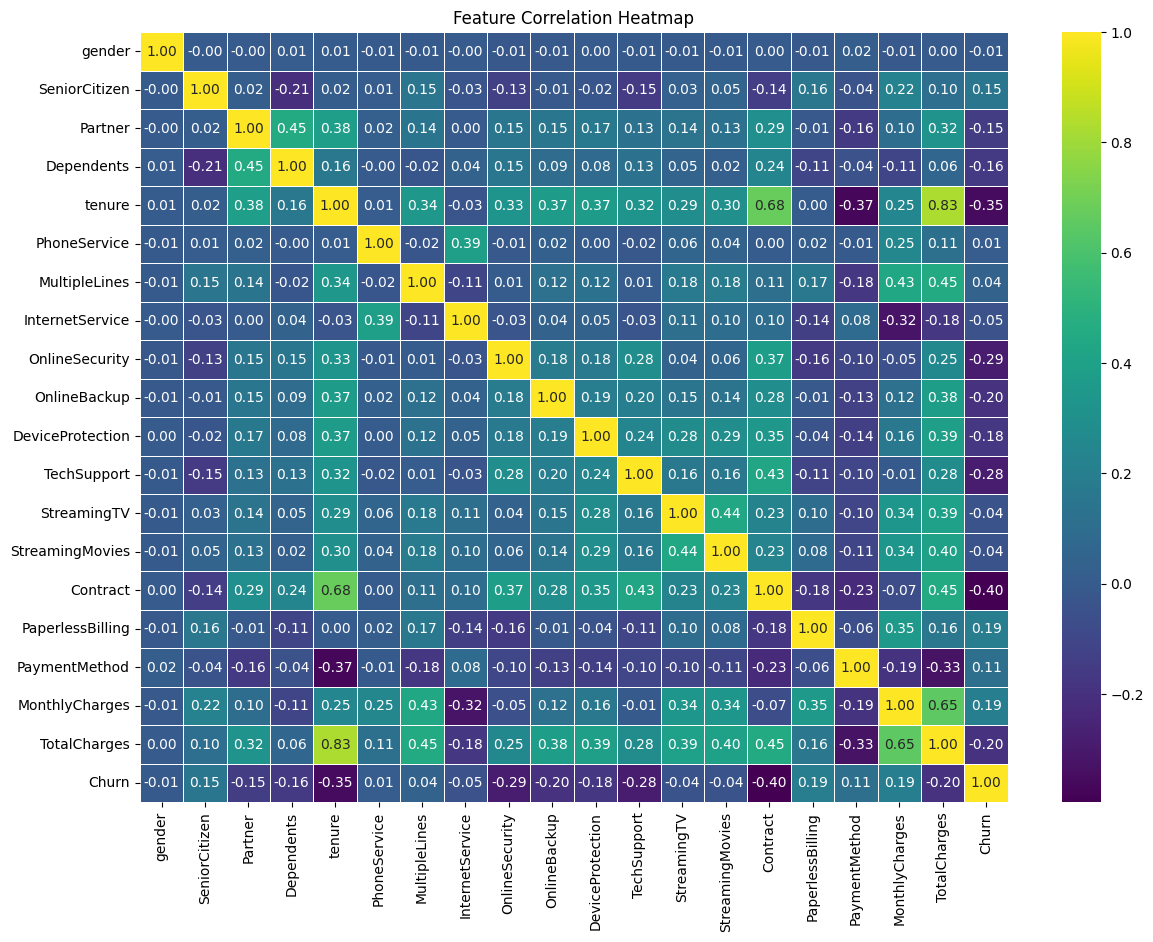

In [16]:
corr = df.select_dtypes(include=np.number).corr()


plt.figure(figsize=(14, 10))

sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap")
plt.show()

In [18]:
import plotly.graph_objects as go


X_plot = df[['TotalCharges', 'MonthlyCharges']]
y_plot = df['Churn']

fig = px.scatter(
    df,
    x='TotalCharges',
    y='MonthlyCharges',
    color='Churn',
    title="XGB – Feature Space"
)

fig.show()

In [8]:
print("Training XGBoost Model...")
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

Training XGBoost Model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [9]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")


Model Accuracy: 77.75%


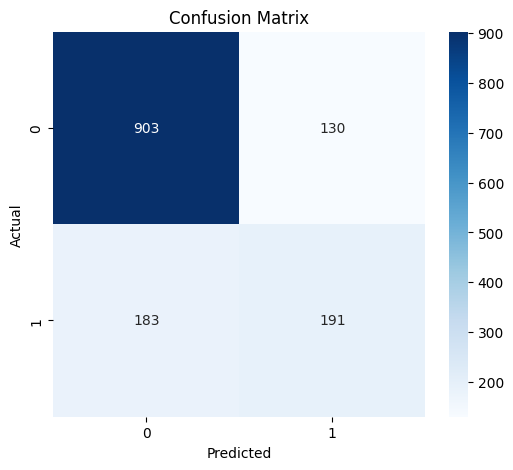

In [10]:
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png')
plt.show()

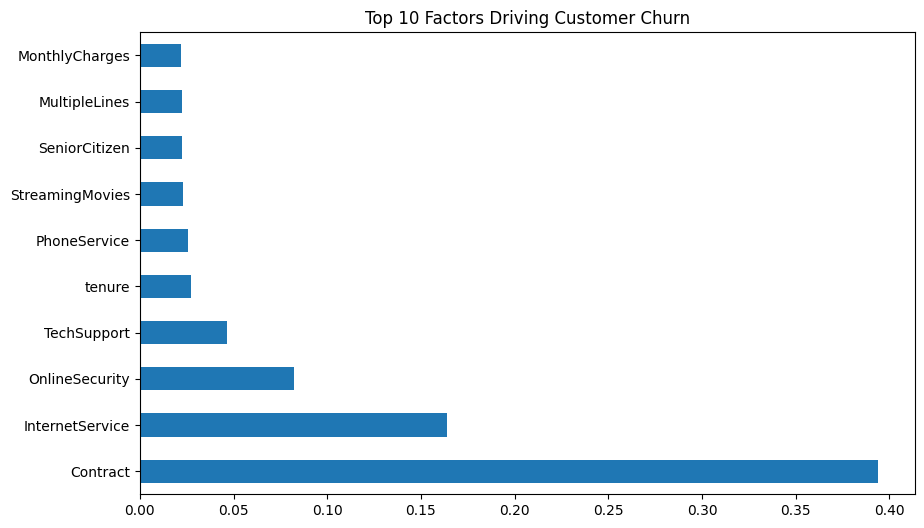

In [11]:
plt.figure(figsize=(10,6))
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Factors Driving Customer Churn')
plt.savefig('feature_importance.png')
plt.show()

In [12]:
y_prob = model.predict_proba(X_test)[:, 1]

fig = px.histogram(
    y_prob,
    nbins=50,
    title="Predicted Churn Probability Distribution"
)

fig.show()

In [13]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=fpr,
    y=tpr,
    mode='lines',
    name=f'AUC = {roc_auc:.2f}'
))

fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash'),
    name='Random'
))

fig.update_layout(
    title='ROC Curve',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate'
)

fig.show()

In [17]:
results = X_test.copy()
results['Actual Churn'] = y_test
results['Predicted Churn'] = y_pred
results['Churn Probability'] = model.predict_proba(X_test)[:, 1] 

results.to_csv('churn_predictions.csv', index=False)
print("Success! Results saved to 'churn_predictions.csv'")

Success! Results saved to 'churn_predictions.csv'
